# Plots for the Thesis

In [9]:
import os
import uproot
import pandas as pd
import awkward as ak
import math
import os
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import seaborn as sn
import nbformat
import sklearn.metrics as metrics
from itertools import combinations
print(nbformat.__version__)

5.10.4


In [10]:
# paths
WEBSITE = '/web/gbrodbek/public_html'
FILEPATH = '/work/gbrodbek/FCC_fullsim/FullSim_TauID/files_for_generation_chain/PlotsForThesis'

## Functions

In [45]:
def plot_ROC_curve(file, decayclass, againstClass=None, figshow=True, savepath=None, log=False):
    if not os.path.exists(file):
        raise FileNotFoundError(f"The file at {file} does not exist.")

    df = pd.read_pickle(file)

    decays = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0', 'Zqq', 'Bhabha']   # check if valid decay mode is given
    if (decayclass not in decays):
        print("Invalid decay mode, please choose from: ", decays)
        return
    
    if (type(againstClass) != list) and (againstClass != 'all') and (againstClass is not None):
        againstClass = [againstClass]
        for decay in againstClass:
            if (decay not in decays):
                print("Invalid decay mode, please choose from: ", decays)
                return

    index_decay = decays.index(decayclass)          # find index of decay mode

    if againstClass is None:   # plot vs all and vs one for all other classes
        # plot the ROC curve against all other classes
        fpr, tpr, thresholds = metrics.roc_curve(df['labels_true'], df[decayclass], pos_label=index_decay)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"all (AUC = {auc:.2f})")
        
        # iterate over all other classes and plot the ROC curve against them
        for i, decay in enumerate(decays):
            if decay == decayclass:    # skip the decay mode itself
                continue
            filter = (df.labels_true == index_decay) | (df.labels_true == i)        # filter only events from the two classes
            labels_filtered = df[filter]['labels_true']
            scores = df[filter][decayclass]
            fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, scores, pos_label=index_decay)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{decay} (AUC = {auc:.2f})")

    elif againstClass == 'all':   # plot one vs rest
        # plot the ROC curve against all other classes
        fpr, tpr, thresholds = metrics.roc_curve(df['labels_true'], df[decayclass], pos_label=index_decay)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"all (AUC = {auc:.2f})")

    else:
        for decay in againstClass:
            if decay == decayclass:    # skip the decay mode itself
                continue
            filter = (df.labels_true == index_decay) | (df.labels_true == decays.index(decay))        # filter only events from the two classes
            labels_filtered = df[filter]['labels_true']
            scores = df[filter][decayclass]
            fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, scores, pos_label=index_decay)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{decay} (AUC = {auc:.2f})")


    plt.title(f"ROC Curves for {decayclass}")    
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", frameon=False, prop={'size': 8})
    if log: plt.xscale('log')
    
    if savepath: plt.savefig(savepath)
    plt.show() if figshow else plt.close()

In [46]:
def plot_conf_matrix(file, log=True, figshow=True, savepath=None, label_list=['e', r'$\mu$', r'$\pi$', r'$\pi \, \pi^0$', r'$\pi \, 2 \pi^0$', r'$3\pi$', r'$3\pi \, \pi^0$', 'background']):
    # Load data
    data = np.genfromtxt(file, delimiter=',', skip_header=1, dtype=None, encoding='utf-8').T
    actual, predicted, counts = data[0], data[1], data[2]

    # Clean up strings and convert counts to float
    actual = np.array([x.strip('"') for x in actual])
    predicted = np.array([x.strip('"') for x in predicted])
    counts = np.array([float(x.strip('"')) for x in counts])

    # Create confusion matrix using crosstab
    df = pd.crosstab(actual, predicted, values=counts, aggfunc='sum', dropna=False)

    # Normalize the confusion matrix by dividing by row sums
    df_normalized = df.div(df.sum(axis=1), axis=0).round(4)  # Normalize by row sum

    fig, ax = plt.subplots()
    # Plot heatmap using the ax object
    if log:
        sn_heatmap = sn.heatmap((df_normalized*100), annot=True, fmt='g', cmap='Blues', 
                xticklabels=label_list, 
                yticklabels=label_list, 
                cbar=True, ax=ax, norm=LogNorm(vmin=1, vmax=100))
    else:
        sn_heatmap = sn.heatmap((df_normalized*100), annot=True, fmt='g', cmap='Blues', 
                xticklabels=label_list, 
                yticklabels=label_list, 
                cbar=True, ax=ax)

    cbar = sn_heatmap.collections[0].colorbar
    cbar.set_label('Normalized Counts in %')

    # Title, labels, and tick rotations
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # No rotation for y-axis labels

    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='black', linewidth=3, fill=False)
    ax.add_patch(rect)

    # Show the plot
    plt.show() if figshow else plt.close()

    # Save the plot
    if savepath:
        fig.savefig(savepath)
    

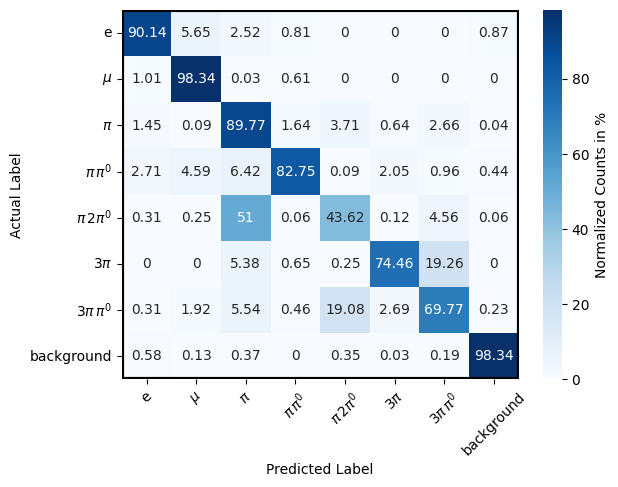

In [47]:
plot_conf_matrix('data_conf/run12.csv', log=False)

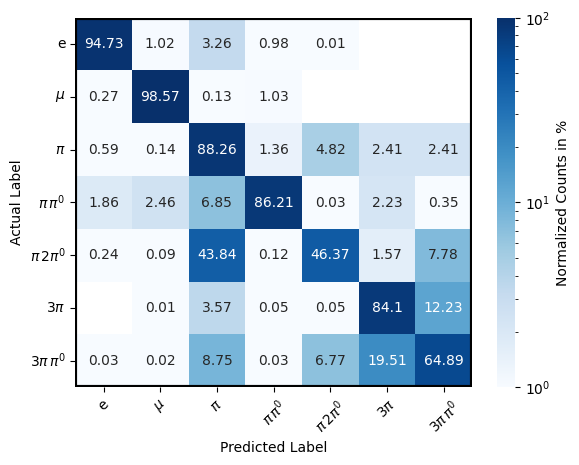

In [48]:
plot_conf_matrix('data_conf/run3.csv', label_list=['e', r'$\mu$', r'$\pi$', r'$\pi \, \pi^0$', r'$\pi \, 2 \pi^0$', r'$3\pi$', r'$3\pi \, \pi^0$'])

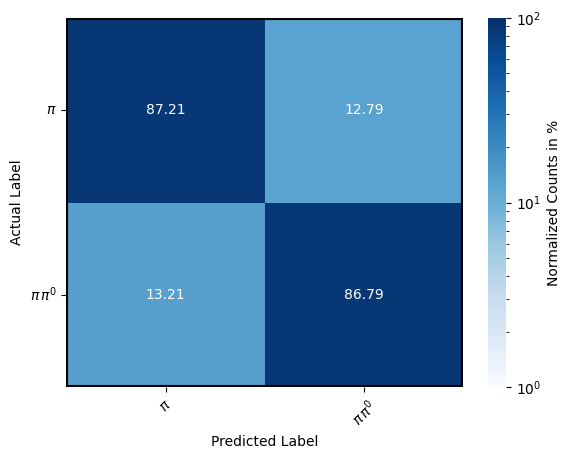

In [49]:
plot_conf_matrix('data_conf/run1.csv', label_list=[r'$\pi$', r'$\pi \, \pi^0$'])

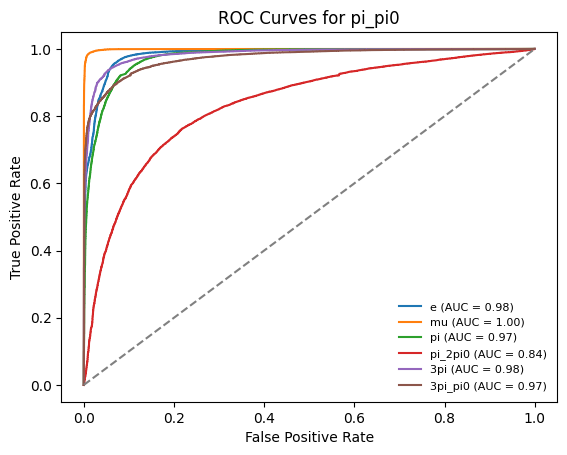

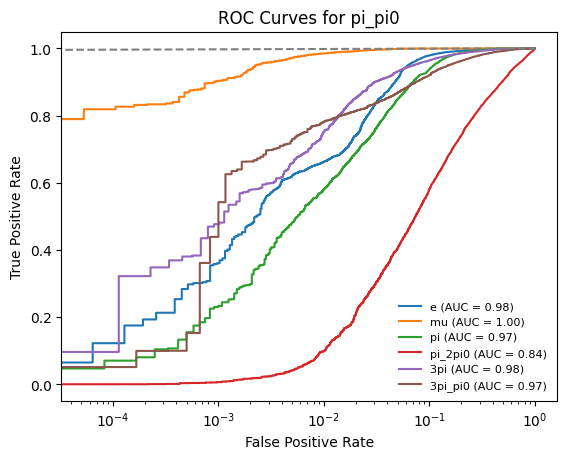

In [50]:
plot_ROC_curve('data_ROC/run3.pt', 'pi_pi0', ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0'], log=False)
plot_ROC_curve('data_ROC/run3.pt', 'pi_pi0', ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0'], log=True)